# Quantum Time Series Analysis: Serial Model (Demo)

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Aims
> *This script aims to create a single qubit serial variational model to fit some data and provide a forecast.*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/qiskit/projects/ts/tqcebt_qtsa',
 '/home/jacob/anaconda3/envs/qiskit/lib/python38.zip',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/lib-dynload',
 '',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages/IPython/extensions',
 '/home/jacob/.ipython',
 '.']

In [2]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.jupyter import *

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils import *

In [3]:
debug = True

## Prepare data
*Values need to be in [0, 1] range*

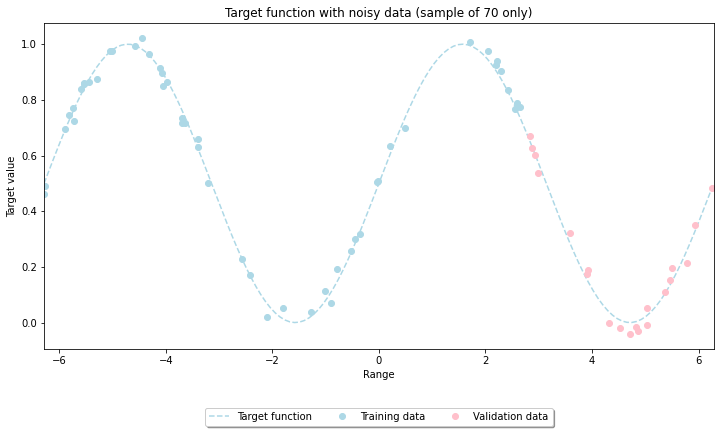

In [4]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
samples_hi_res = samples*2
train_pc = samples_train / samples

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_sin()

### Collect target function parameters
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T   = (ub - lb)

### Prepare all X and y data
X_all   = np.linspace(lb, ub, num=samples_hi_res)
y_all   = f.fun(X_all)
X_train = (ub_train - lb_train) * algorithm_globals.random.random(samples_train) + lb_train
X_train = np.sort(X_train, axis = 0)
y_train = f.fun(X_train) + eps * (algorithm_globals.random.random(samples_train) - 0.5)
X_valid = (ub_valid - lb_valid) * algorithm_globals.random.random(samples_valid) + lb_valid
X_valid = np.sort(X_valid, axis = 0)
y_valid = f.fun(X_valid) + eps * (algorithm_globals.random.random(samples_valid) - 0.5)

### Reshape Xs for fitting, scoring and prediction
X_all   = X_all.reshape(samples_hi_res, 1)
X_train = X_train.reshape(samples_train, 1)
X_valid = X_valid.reshape(samples_valid, 1)

### Plot the target function and data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Target function with noisy data (sample of "+str(samples)+" only)")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.xlim(lb, ub)

plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')
plt.plot(X_train, y_train, color='lightblue', marker='o', linestyle='None', label='Training data')
plt.plot(X_valid, y_valid, color='pink', marker='o', linestyle='None', label='Validation data')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=True)
plt.show()

## Create a serial model to fit data

In [5]:
### Define quantum instance, fix random seeds to replicate results only, otherwise remove
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100, seed_simulator=2022, seed_transpiler=2022)

### Create a serial model and test it

ParameterView([Parameter(W[0]), Parameter(W[10]), Parameter(W[11]), Parameter(W[1]), Parameter(W[2]), Parameter(W[3]), Parameter(W[4]), Parameter(W[5]), Parameter(W[6]), Parameter(W[7]), Parameter(W[8]), Parameter(W[9]), Parameter(X)])


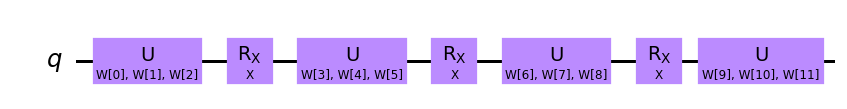

In [6]:
### Create a custom serial model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor

def serial_fourier_model(layers):
    
    ansatz = QuantumCircuit(1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        param_w_0 = Parameter(label+'['+str(pno)+']')
        param_w_1 = Parameter(label+'['+str(pno+1)+']')
        param_w_2 = Parameter(label+'['+str(pno+2)+']')
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')

    return ansatz    

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(3)

# Show all parameters, the last is X
print(m.parameters)

# Show the circuit
m.draw(output='mpl', scale=1.5, fold=True)

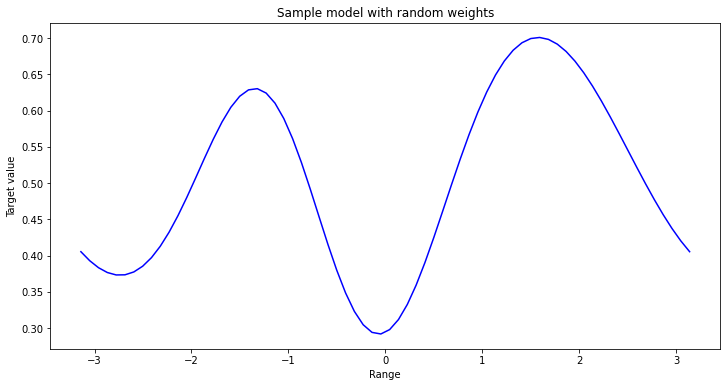

In [7]:
### Test a serial model
#   - Note that when layers=1 it will always generate a sine/cosine function
#   - Without a random seed it will produce a different function every time

if debug:

    # Start the random process
    algorithm_globals.random_seed = 2022

    # Define the ansatz architecture and prepare X, y vectors
    layers = 5
    x_vect = np.linspace(-np.pi, np.pi, 70)
    y_vect = []
    
    # Initialise all parameters to random values (X is last)
    param_vals = algorithm_globals.random.random((layers+1)*3+1) * 2 * np.pi

    # Use ansatz to generate x, y pairs
    for x in x_vect:
        
        # Create a circuit for each new value of x
        model = serial_fourier_model(layers)
        param_vals[-1] = x
        init_weights = param_vals[:-1]
        model_inst = model.bind_parameters(param_vals)

        # Generate y as expectation value of measuring '0'
        backend = Aer.get_backend('statevector_simulator') 
        result = execute(model_inst,backend).result()
        counts = result.get_counts()
        y_vect.append(counts['0'])

    # Plot the curve
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title("Sample model with random weights")
    plt.xlabel("Range")
    plt.ylabel("Target value")
    plt.plot(x_vect, y_vect, color='blue')
    plt.show()

### Construct a model

In [8]:
### Define QNN

# Start random process
algorithm_globals.random_seed = 2022
np.random.seed(2022)

# Define model, its parameters and their initial values (including random input)
layers = 3 # 9 # 15 # 21 # 27 # 33
model = serial_fourier_model(layers)
init_weights = 2 * np.pi * algorithm_globals.random.random((layers+1)*3)

# Construct QNN and show its circuit
regr_qnn = CircuitQNN(model, 
            input_params=[model.parameters[-1]], 
            weight_params=model.parameters[:-1], 
            quantum_instance=quantum_instance)

print('QTSA serial model built')

QTSA serial model built


In [9]:
### Define a regressor

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500)
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500)
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16)
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks
optimizer = COBYLA(maxiter=100)
regr_callback = Regr_callback(log_interval=20)
regr_callback.reset(obfun=[])

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss="squared_error",
    optimizer=optimizer, 
    initial_point=init_weights, 
    callback=regr_callback.graph
)

print('Regressor with', optimizer.setting.splitlines()[0])
optimizer.settings

Regressor with Optimizer: COBYLA


{'max_evals_grouped': 1,
 'options': {'maxiter': 100, 'disp': False, 'rhobeg': 1.0},
 'tol': None}

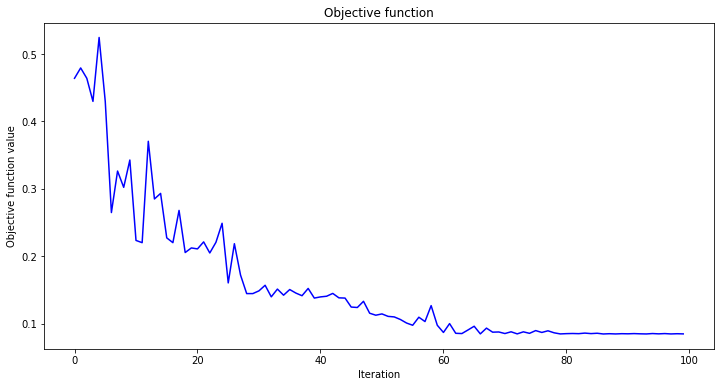

Optimum objective function value: (86, 0.08469078559832337)


In [10]:
### Train the model

# Start random process
algorithm_globals.random_seed = 2022
np.random.seed(2022)

# Fit to data and plot progress
regressor.fit(X_train, y_train) 

### Find the optimum objective fun value and NN weights
print('Optimum objective function value:', regr_callback.min_obj())

## Score the model

In [11]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

yp_fun = np.array([yi for yi in f.fun(X_train)])
print('R2 for training data vs ground truth:\t', r2_score(yp_fun, y_train), '\n')

yp_train = np.array([[1-yi, yi] for yi in y_train])
yp_train_hat = np.array([y1 for y0, y1 in regressor.predict(X_train)])
print('R2 for pred vs training data:\t\t', regressor.score(X_train, yp_train))
print('MAPE for pred vs training data:\t\t', mean_absolute_percentage_error(y_train, yp_train_hat), '\n')

yp_valid = np.array([[1-yi, yi] for yi in y_valid])
yp_valid_hat = np.array([y1 for y0, y1 in regressor.predict(X_valid)])
print('R2 for pred vs validation data:\t\t', regressor.score(X_valid, yp_valid))
print('MAPE for pred vs validation data:\t', mean_absolute_percentage_error(y_valid, yp_valid_hat))

R2 for training data vs ground truth:	 0.9918349791907765 

R2 for pred vs training data:		 0.8373704103543252
MAPE for pred vs training data:		 0.23869612077018526 

R2 for pred vs validation data:		 0.7506888030680641
MAPE for pred vs validation data:	 3.1629696794186093


## Find the fit and predictions

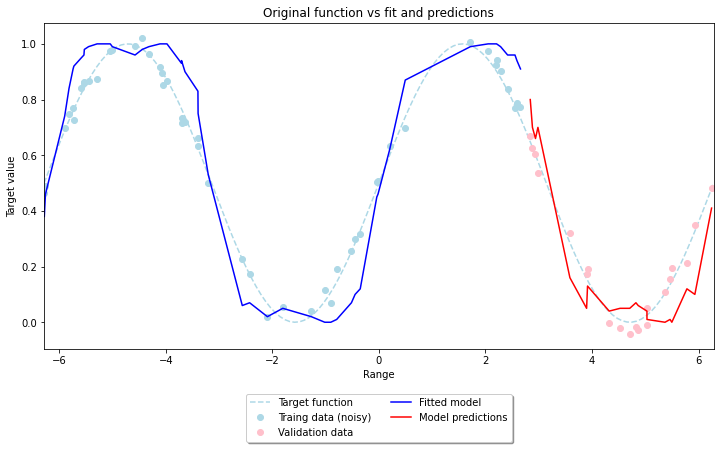

In [12]:
### Find predictions for the past and future data
yp_train_hat = regressor.predict(X_train)
yp_train_hat = np.array([yi[1] for yi in yp_train_hat])
yp_valid_hat = regressor.predict(X_valid)
yp_valid_hat = np.array([yi[1] for yi in yp_valid_hat])

# Prepare the plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs fit and predictions")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.xlim(lb, ub)

# Plot target function
plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')

# Plot fitted line
# - Note that [P(-1),P(1)] is predicted
plt.plot(X_train, y_train, color='lightblue', marker='o', linestyle='None', label='Traing data (noisy)')
plt.plot(X_valid, y_valid, color='pink', marker='o', linestyle='None', label='Validation data')
plt.plot(X_train, yp_train_hat, color='blue', label='Fitted model')
plt.plot(X_valid, yp_valid_hat, color='red', linestyle='solid', label='Model predictions')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

### Versions
- V8 (29/8/2022)
    - V8.9 - Prepared for the TQCEBT workshop as a demo

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table